Based on the DE marker results, as well as the aggregated scType cluster scores per cell type (ie, some of the top scores were not much larger than the second highest score), we decided clusters 2, 6, and 9 may be a mixture of cells that need to be further sub-clusterd

In [5]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    library(data.table, quietly = T)
    library(gtools, quietly = T)
    
    library(ggplot2, quietly = T)
    library(RColorBrewer, quietly = T)
})

sctype_path = '/data2/hratch/Software/'
data_path = '/data3/hratch/STAT4_v2/'

In [6]:
pbmc.integrated<-readRDS(paste0(data_path, 'interim/pbmc_sctype_annotated.RDS'))

# Subclustering

To subcluster, we 1) subset to the cluster of interest then 2) re-run PCA and clustering on the subset.   

We expect 3-4 subclusters for cluter 2, 3 subclusters for cluster 6, and 2 subclusters for cluster 9, . We adjust the resolution parameter accordingly

Note, this uses the HVGs of the full batch-corrected data. This should still provide us enough resolution. If necessary, can go back and reprocess entirely from raw counts prior to clustering. 

In [644]:
pca.var<-function(so, n_pcs_test = 100, pc.thresh = 0.15){
    total_variance <- sum(matrixStats::rowVars(so@assays$integrated@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point()
    if (n_pcs <= n_pcs_test){g<-g+geom_vline(xintercept = n_pcs, color = 'blue')}
    
    return(list(n.pcs = min(30, n_pcs), pc.var.graph = g))
}

subcluster<-function(so, cluster_label, resolution = 0.5, n_pcs_test = 100){
    suppressWarnings({
        suppressMessages({
            pbmc.subset<-subset(pbmc.integrated, seurat_clusters == cluster_label)
            pbmc.subset<-RunPCA(pbmc.subset, npcs = n_pcs_test, verbose=FALSE)
            # npcs is min(PC where more than 0.1% of var is no longer explained or 30)
            pca.res<-pca.var(pbmc.subset, n_pcs_test = n_pcs_test) 
            pbmc.subset <- FindNeighbors(pbmc.subset, reduction = "pca", dims = 1:pca.res$n.pcs)
            pbmc.subset <- FindClusters(pbmc.subset, resolution = resolution)
            pbmc.subset <- RunUMAP(pbmc.subset, reduction = "pca", dims = 1:pca.res$n.pcs)
        })
    })

    g<-DimPlot(pbmc.subset)
    
    res<-list(so.subset = pbmc.subset, 
              n.pcs = pca.res$n.pcs, pc.var.graph = pca.res$pc.var.graph, 
             umap.graph = g)
    return(res)
    
}

Cluster 2 gives 4 clusters:

In [645]:
res.c2<-subcluster(so = pbmc.integrated, cluster_label = '2', resolution = 0.15)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2082
Number of edges: 92731

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8788
Number of communities: 4
Elapsed time: 0 seconds


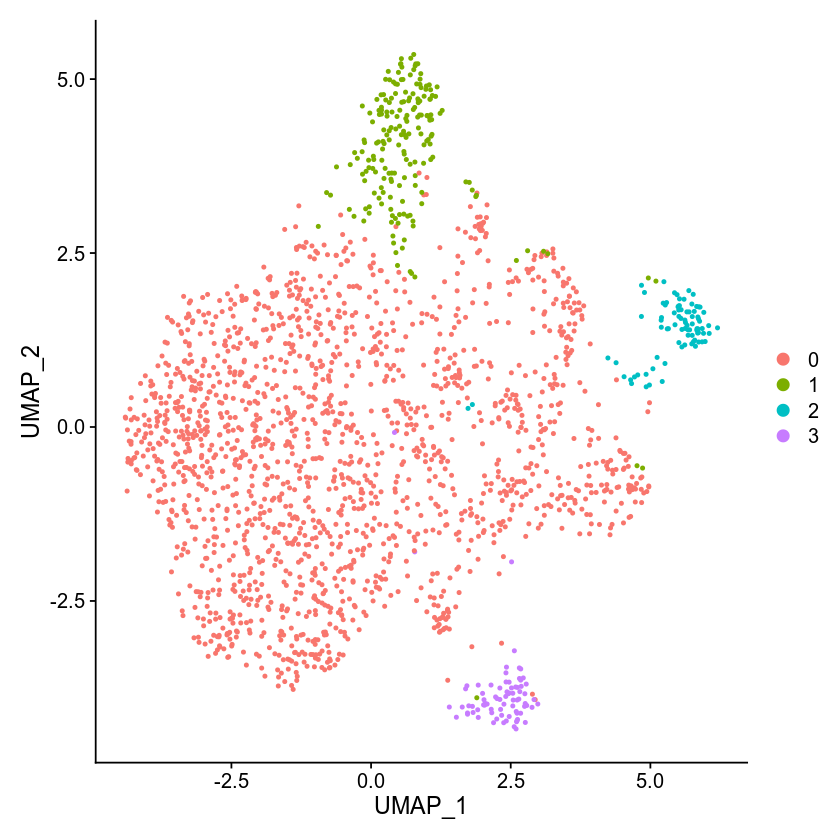

In [88]:
res.c2$umap.graph

In [74]:
res.c6<-subcluster(so = pbmc.integrated, cluster_label = '6', resolution = 0.2)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 947
Number of edges: 50454

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8231
Number of communities: 3
Elapsed time: 0 seconds


Cluster 6 gives 3 clusters:

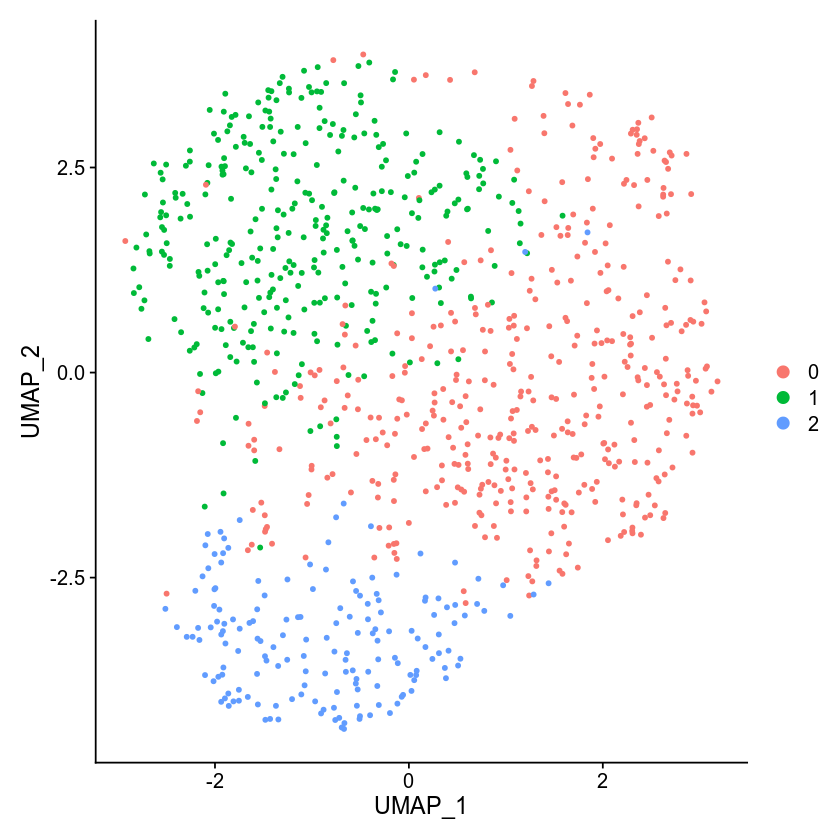

In [75]:
res.c6$umap.graph

Cluster 9 gives X clusters:

In [83]:
res.c9<-subcluster(so = pbmc.integrated, cluster_label = '9', resolution = 0.2)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 385
Number of edges: 16698

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8571
Number of communities: 2
Elapsed time: 0 seconds


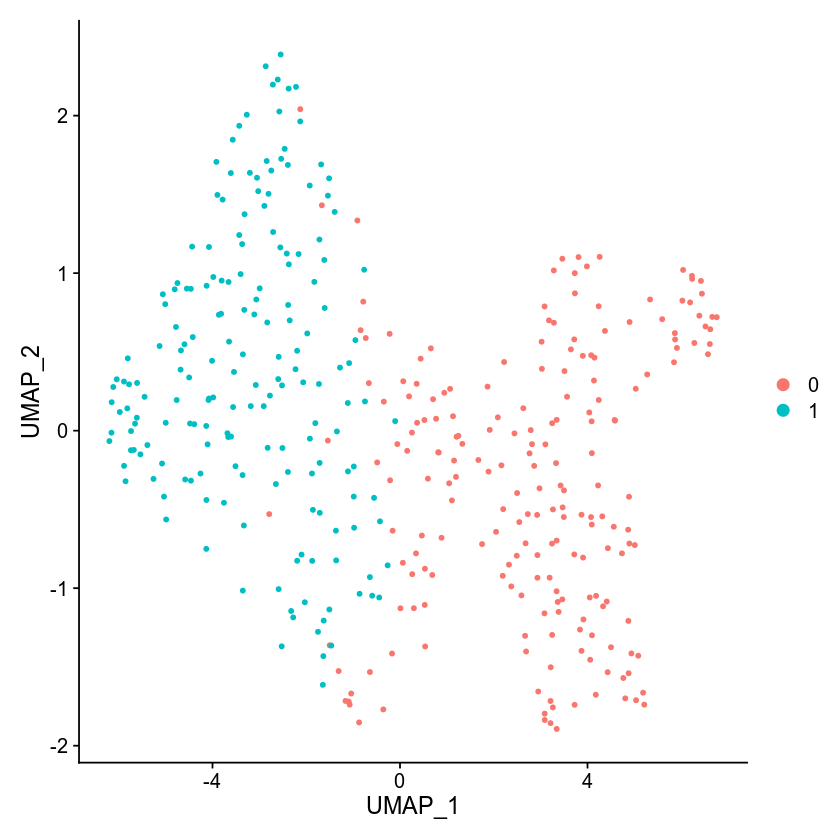

In [80]:
res.c9$umap.graph

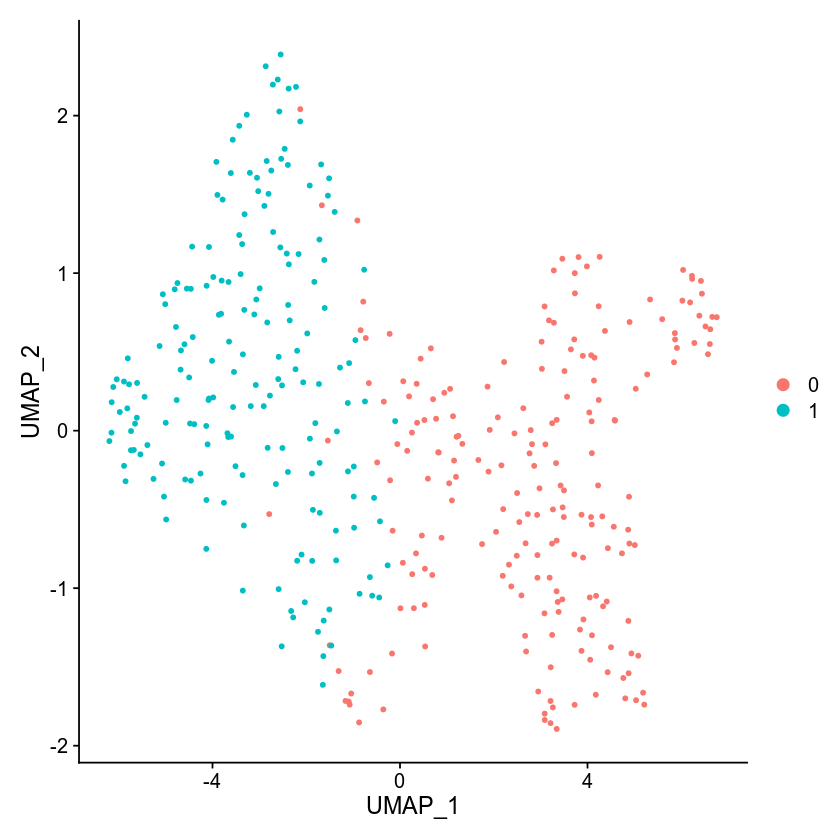

In [84]:
res.c9$umap.graph

# Markers

We repeat the marker wilcoxon method from before (02Ci), but this time, each of clusters 2, 6, and 9 are reannotated as new clusters with their subclusters. It's still one vs rest, so a subcluster of 2, for example, is tested against ALL other cells in the dataset (including other cells in cluster 2 and other cells otuside of cluster 2). 

## Mapping

First, must map cluster labels of subsets. So for cluster 2 with 4 subclusters since there are currently 16 present, this will become clusters 2, 17, 18, 19 (or also 2A-2D).

In [138]:
relabel.clusters<-function(so.subset, cluster.label.og, label.start){
    md<-so.subset@meta.data['seurat_clusters']
    n.clusters<-length(unique(md$seurat_clusters))
    cluster.labels<-sort(unique(as.numeric(md$seurat_clusters))) - 1

    cluster.labels.no<-c(cluster.label.og, 
                         seq(label.start+1, label.start+n.clusters - 1, by = 1))
    names(cluster.labels.no)<-as.character(cluster.labels)

    cluster.labels.let<-as.character(paste0(cluster.label.og, LETTERS[1:n.clusters]))
    md[['cluster.labels.no']]<-cluster.labels.no[md$seurat_clusters]
    md[['cluster.labels.let']]<-cluster.labels.let[md$seurat_clusters]
    
    so.subset@meta.data<-md
    
    return(list(so.subset = so.subset, max.cluster = max(cluster.labels.no)))
}

In [130]:
# cluster 2
clust.relabel.2<-relabel.clusters(so.subset = res.c2$so.subset, 
                                 cluster.label.og = 2, 
                                 label.start=max(as.numeric(pbmc.integrated@meta.data$seurat_clusters)) - 1)
res.c2[['so.subset']]<-clust.relabel.2$so.subset
label.start<-clust.relabel.2$max.cluster

# cluster 6
clust.relabel.6<-relabel.clusters(so.subset = res.c6$so.subset, 
                                 cluster.label.og = 6, 
                                 label.start=label.start)
res.c6[['so.subset']]<-clust.relabel.6$so.subset
label.start<-clust.relabel.6$max.cluster

# cluster 9
clust.relabel.9<-relabel.clusters(so.subset = res.c9$so.subset, 
                                 cluster.label.og = 9, 
                                 label.start=label.start)
res.c9[['so.subset']]<-clust.relabel.9$so.subset
label.start<-clust.relabel.9$max.cluster

In [150]:
res.clusters=list('2' = res.c2, 
                 '6' = res.c6, 
                 '9' = res.c9)

mapper.no<-c()
mapper.label<-c()
for (x in res.clusters){
    mapper.no<-c(mapper.no, setNames(x$so.subset@meta.data$cluster.labels.no, rownames(x$so.subset@meta.data)))
    mapper.label<-c(mapper.label, setNames(x$so.subset@meta.data$cluster.labels.let, rownames(x$so.subset@meta.data)))
}

In [ ]:
md<-pbmc.integrated@meta.data

md[['seurat_subcluster_no']]<-as.numeric(md$seurat_clusters) - 1
md[names(mapper.no), 'seurat_subcluster_no']<-unname(unlist(mapper.no))
md[['seurat_subcluster_no']]<-factor(x = md$seurat_subcluster_no,
                                     levels = sort(unique(md$seurat_subcluster_no)))

md[['seurat_subcluster_let']]<-as.character(md$seurat_clusters) 
md[names(mapper.label), 'seurat_subcluster_let']<-unname(unlist(mapper.label))
md[['seurat_subcluster_let']]<-factor(x = md$seurat_subcluster_let,
                                     levels = mixedsort(unique(md$seurat_subcluster_let)))
pbmc.integrated@meta.data<-md

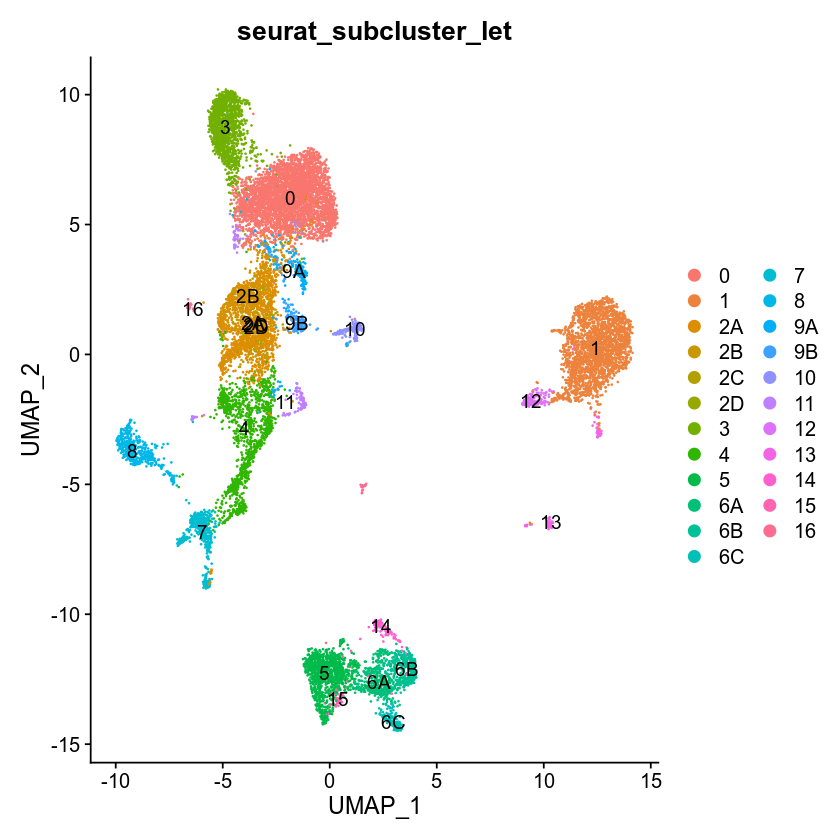

In [210]:
DimPlot(pbmc.integrated, 
       group.by = 'seurat_subcluster_let', label = T)

## DotPlots

In [220]:
markers.present<-colnames(fread(paste0(data_path, 'interim/scType_pos_markers.txt'))) # from 02Ci

In [222]:
Idents(pbmc.integrated)<-'seurat_subcluster_let'

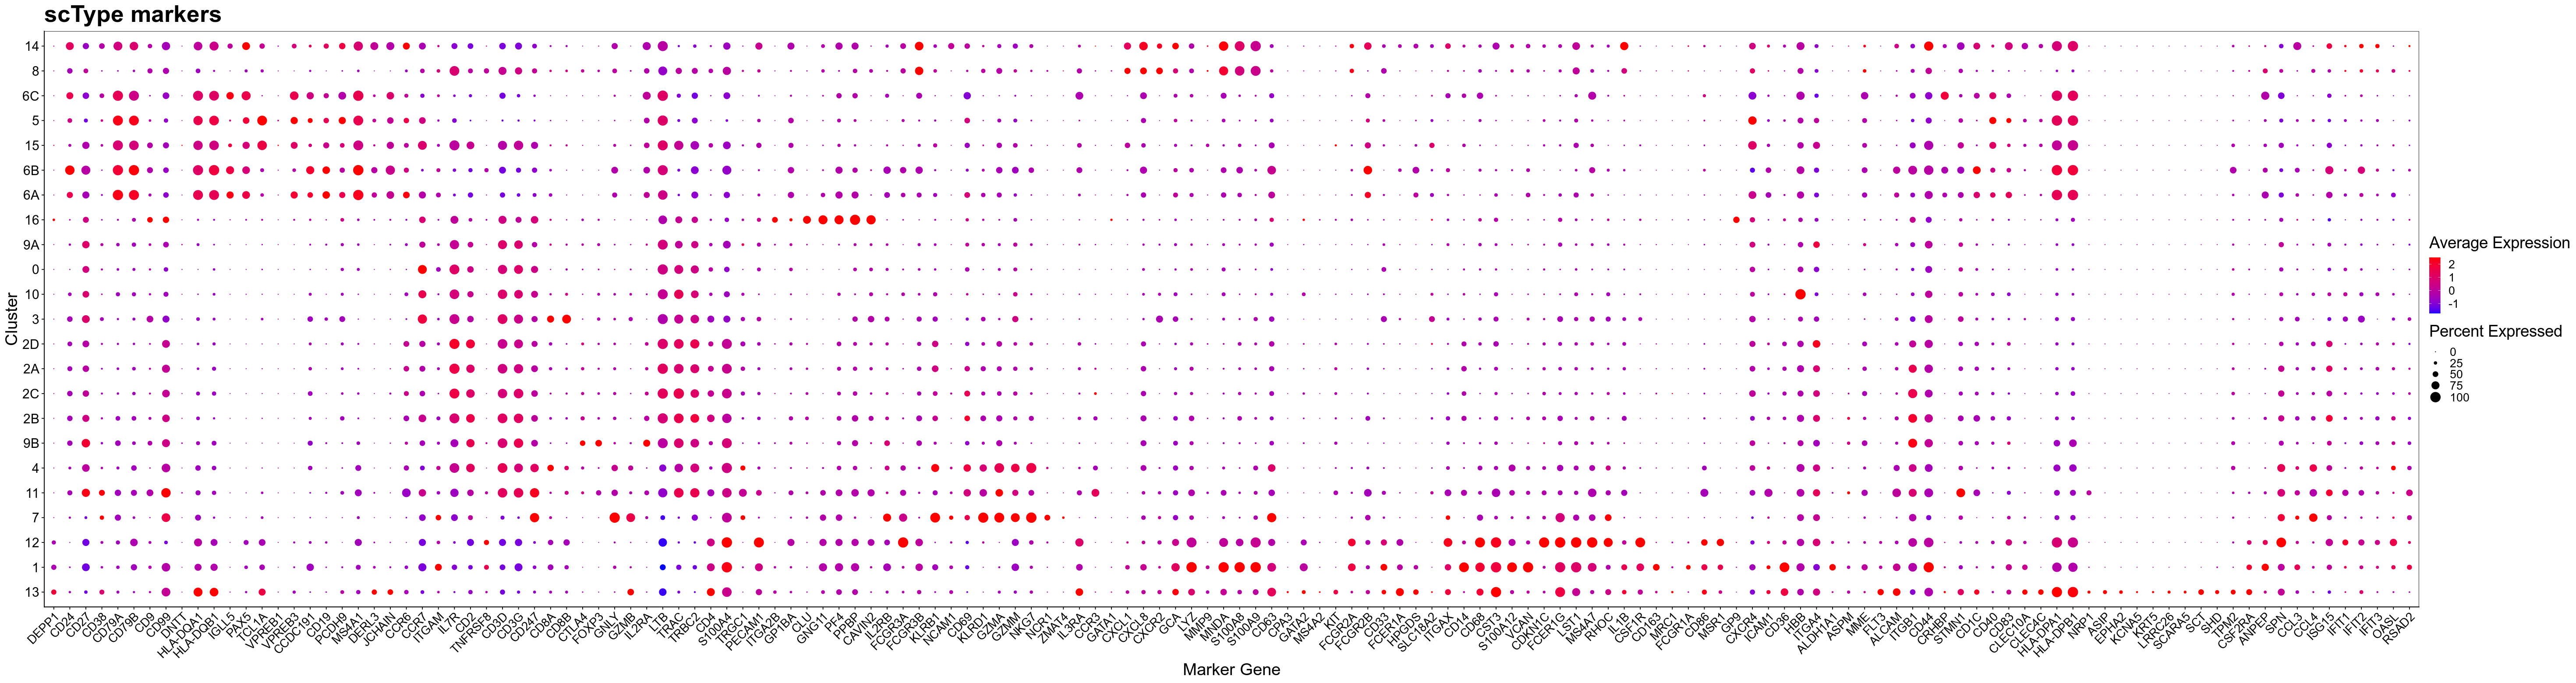

In [225]:
h_ = 13
w_ = 49
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 16))
suppressWarnings({
    g<-DotPlot(pbmc.integrated, features = markers.present, cols = c('blue', 'red'), cluster.idents = T) + 
    RotatedAxis()+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("scType markers")
})

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'subclusters_scType_marker_dotplot', ext), g, 
                                             height = h_, width = w_)}

g

## DE

Since the Wilcoxon alone worked well last time, we can just proceed with this.

In [240]:
Idents(pbmc.integrated)<-'seurat_subcluster_let'
subclusters<-sort(unique(md[md$seurat_clusters %in% c('2', '6', '9'), 'seurat_subcluster_let']))

In [302]:
markers.wilcoxon<-list()
for (subcluster in subclusters){
    de.res<-FindMarkers(object = pbmc.integrated, 
                                    ident.1 = subcluster,
                                    assay = 'RNA', only.pos = T, 
                                       slot = 'data', test.use = 'wilcox', 
                                       min.pct = 0.25, # stringent since markers
                                        logfc.threshold = 0.5, 
                                      )
    de.res[['gene']]<-rownames(de.res)
    de.res[['seurat_cluster_let']]<-subcluster
    
    markers.wilcoxon[[subcluster]]<-de.res
}
saveRDS(markers.wilcoxon, paste0(data_path, 'interim/subcluster_markers.RDS'))

In [315]:
markers.wilcoxon<-readRDS(paste0(data_path, 'interim/subcluster_markers.RDS'))

In [316]:
# format markers
marker.excel<-function(marker, de.type = 'wilcoxon'){
    markers_workbook<-createWorkbook()
    for (cluster in mixedsort(unique(marker$seurat_cluster_let))){
        de.res.cl<-as.data.frame(marker[marker$seurat_cluster_let == cluster, ])
        rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]

        addWorksheet(markers_workbook, cluster)
        writeData(markers_workbook, sheet = cluster, x = de.res.cl)
    }
    saveWorkbook(markers_workbook, overwrite = T, 
                 paste0(data_path, 'interim/', de.type, '_subcluster_markers.xlsx'))
}

# additional formatting and filtering
marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= 0.05,] # threshold on p_adj
marker<-marker[marker$avg_log2FC > 1.5,] # further threshold on LFC
marker<-marker[with(marker, order(seurat_cluster_let, -avg_log2FC)), ] # sort by effect size
md.subs<-md[md$seurat_clusters %in% c('2', '6', '9') ,]
mapper<-setNames(md.subs$seurat_subcluster_no, md.subs$seurat_subcluster_let)
marker[['seurat_subcluster_no']]<-unlist(unname(mapper[marker$seurat_cluster_let]))
marker.excel(marker) # save to excel file

# Focus on: Cluster 2

While cluster 6 and 9 were clear now, we still didn't feel cluster 2 was super well resolved. 

So, we will try a few more things:

1) Look at markers exclusive to the cluster 2 subclusters (e.g. 2A vs 2B-2D rather than vs rest)
2) Use scType to annotate the subclusters (both using all cells and just the cluster 2 subclusters)

In [320]:
cluster_label = '2'
pbmc.subset.c2<-subset(pbmc.integrated, seurat_clusters == cluster_label)

## Subcluster-specific DE

*Note, used different LFC/p_val_adj thresholds bc otherwise no DE genes. 

In [384]:
# just within cluster 2
markers.wilcoxon<-list()
for (subcluster in unique(pbmc.subset.c2$seurat_subcluster_let)){
    de.res<-FindMarkers(object = pbmc.subset.c2, 
                                    ident.1 = subcluster,
                                    assay = 'RNA', only.pos = F, 
                                       slot = 'data', test.use = 'wilcox', 
                                       min.pct = 0.25, # stringent since markers
                                        logfc.threshold = 0.5, 
                                      )
    de.res[['gene']]<-rownames(de.res)
    de.res[['seurat_cluster_let']]<-subcluster
    
    markers.wilcoxon[[subcluster]]<-de.res
}
saveRDS(markers.wilcoxon, paste0(data_path, 'interim/subcluster_cluster2only_markers.RDS'))

In [396]:
markers.wilcoxon<-readRDS(paste0(data_path, 'interim/subcluster_cluster2only_markers.RDS'))

In [397]:
# format markers
marker.excel<-function(marker, de.type = 'wilcoxon'){
    markers_workbook<-createWorkbook()
    for (cluster in mixedsort(unique(marker$seurat_cluster_let))){
        de.res.cl.1<-as.data.frame(marker[marker$seurat_cluster_let == cluster, ])
        for (lfc.type in c('pos', 'neg')){
            if (lfc.type == 'pos'){
                de.res.cl<-de.res.cl.1[de.res.cl.1$avg_log2FC > 0, ]
            }else{
                de.res.cl<-de.res.cl.1[de.res.cl.1$avg_log2FC < 0, ]
            }
            if (dim(de.res.cl)[[1]] > 0){rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]}

            addWorksheet(markers_workbook, paste0(cluster, '_', lfc.type))
            writeData(markers_workbook, sheet = paste0(cluster, '_', lfc.type), x = de.res.cl)
        }
    }
    saveWorkbook(markers_workbook, overwrite = T, 
                 paste0(data_path, 'interim/', de.type, '_subcluster_cluster2only_markers.xlsx'))
}

marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= 0.1,] # threshold on p_adj
# marker<-marker[abs(marker$avg_log2FC) > 1.5,] # further threshold on LFC

# map
md.subs<-pbmc.integrated@meta.data[pbmc.integrated@meta.data$seurat_clusters =='2' ,]
mapper<-setNames(md.subs$seurat_subcluster_no, md.subs$seurat_subcluster_let)
mapper<-setNames(sort(unique(md.subs$seurat_subcluster_no)), 
         sort(unique(md.subs$seurat_subcluster_let)))
marker[['seurat_subcluster_no']]<-unlist(unname(mapper[marker$seurat_cluster_let]))
marker.excel(marker)

## scType 

In [371]:
source(paste0(sctype_path, 'sc-type/', 'R/gene_sets_prepare.R'))
source(paste0(sctype_path, 'sc-type/', 'R/sctype_score_.R'))       
db_<-paste0(sctype_path, 'sc-type/', 'ScTypeDB_full.xlsx')

tissue = "Immune system" 
# prepare gene sets
suppressWarnings({
    suppressMessages({
        gs_list = gene_sets_prepare(db_, tissue)
    })
})

### on all cells, including subclusters

In [372]:
md<-pbmc.integrated@meta.data

In [380]:
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = pbmc.integrated@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_subcluster_let), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_subcluster_let==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_subcluster_let==cl)), 10)
}))

write.csv(cL_resutls, 
         paste0(data_path, 'interim/celltype_subcluster_scores.csv'))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"

sctype_scores<-sctype_scores[with(sctype_scores, order(cluster)), ]
sctype_scores

cluster,type,scores,ncells,freq
<fct>,<chr>,<dbl>,<int>,<dbl>
0,Naive CD4+ T cells,4486.4331,3765,24.7925721
1,Classical Monocytes,9411.4308,2351,15.4813644
2A,Naive CD4+ T cells,1880.6156,1723,11.3459766
2B,Naive CD4+ T cells,221.9160,195,1.2840774
2C,Effector CD4+ T cells,106.2735,86,0.5663111
2D,Naive CD4+ T cells,104.0537,78,0.5136310
3,Naive CD8+ T cells,2317.7779,1328,8.7448966
4,CD8+ NKT-like cells,3652.6530,1276,8.4024760
5,Naive B cells,5221.0587,1123,7.3949691


### on just the cluster 2subclusters

In [377]:
md<-pbmc.subset.c2@meta.data

In [381]:
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = pbmc.subset.c2@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_subcluster_let), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_subcluster_let==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_subcluster_let==cl)), 10)
}))

write.csv(cL_resutls, 
         paste0(data_path, 'interim/celltype_subcluster_cluster2only_scores.csv'))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"

sctype_scores<-sctype_scores[with(sctype_scores, order(cluster)), ]
sctype_scores

cluster,type,scores,ncells,freq
<fct>,<chr>,<dbl>,<int>,<dbl>
2A,Naive CD4+ T cells,1880.6156,1723,82.756964
2B,Naive CD4+ T cells,221.9160,195,9.365994
2C,Effector CD4+ T cells,106.2735,86,4.130644
2D,Naive CD4+ T cells,104.0537,78,3.746398


# Annotation

Based on the subcluster markers, we decided on the following mapping:

In [431]:
mapper<-setNames(c('Effector CD4+ T cells', 'Memory CD4+ T cells','Effector CD4+ T cells', 'Memory CD4+ T cells', 
                 'Plasma B cells', 'Pre-B cells', 'Memory B cells', 
                 'γδ-T cells', 'Regulatory CD4+ T cells'),
                c('2A', '2B', '2C', '2D', 
                  '6A', '6B', '6C', 
                  '9A', '9B'))
mapper

2A                        2B                        2C 
  "Effector CD4+ T cells"     "Memory CD4+ T cells"   "Effector CD4+ T cells" 
                       2D                        6A                        6B 
    "Memory CD4+ T cells"          "Plasma B cells"             "Pre-B cells" 
                       6C                        9A                        9B 
         "Memory B cells"              "γδ-T cells" "Regulatory CD4+ T cells"

Map to metadata

In [432]:
md<-pbmc.integrated@meta.data
names(md)[names(md) == 'Cell.Type'] <- 'Cell.Type.scType' # rename original annotation column
md[['Cell.Type']]<-as.character(md$Cell.Type.scType) # transfer original annotations
# map new annotations
cell.torelabel<-rownames(md[md$seurat_subcluster_let %in% names(mapper), ])
md[cell.torelabel, 'Cell.Type']<-unlist(unname(mapper[as.character(md[cell.torelabel, 
                                                                      'seurat_subcluster_let'])]))

# set factor levels
co<-c('Naive CD4+ T cells', 'Effector CD4+ T cells', 'Memory CD4+ T cells', 'Regulatory CD4+ T cells', 
       'Naive CD8+ T cells', 'γδ-T cells', 'CD8+ NKT-like cells', 'Natural killer  cells', 
       'Naive B cells', 'Pre-B cells', 'Plasma B cells', 'Memory B cells',
 'Plasmacytoid Dendritic cells', 'Classical Monocytes', 'Non-classical monocytes', 'Neutrophils',
  'Erythroid-like and erythroid precursor cells', 'Platelets'
 )
md[['Cell.Type']]<-factor(x = md$Cell.Type,levels = co)
pbmc.integrated@meta.data<-md

In [637]:
md<-pbmc.integrated@meta.data
write.csv(md, paste0(data_path, 'processed/pbmc_integrated_metadata.csv'))

Idents(pbmc.integrated)<-'Cell.Type'
saveRDS(pbmc.integrated, file = paste0(data_path, 'processed/pbmc_integrated.RDS'))

Metadata cluster label guidelines:
- "seurat_clusters": the original cluster annotations from Seurat
- "Cell.Type.scType": the original scType annotations on "seurat_clusters"
- "seurat_subcluster_let": final cluster labels including
    - 4 subclusters for the original cluster 2 (2A-2D)
    - 3 subclusters for the original cluster 6 (6A-6C)
    - 2 subclusters for the original cluster 9 (9A-9B)
- "seurat_subcluster_no": final cluster labels, same as seurat_subcluster_let but with new numbers rather than letters, including
    - 4 subclusters for the original cluster 2 (2, 17-19)
    - 3 subclusters for the original cluster 6 (6, 20-21)
    - 2 subclusters for the original cluster 9 (9, 22)
- "Cell.Type": final cell type annotations on seurat_subcluster

Note, the final annotations are the same as the original annotations except for the subclusters. 

## Visualize Final Cell Types

Since a single cell type mapped to multiple clusters in some cases, we want to distinguish between these in the visualization to see whether or not they are near each other in UMAP space. 

We can see how many clusters each cell type mapped to:

In [610]:
md<-pbmc.integrated@meta.data
cluster.label<-'seurat_subcluster_let' #'seurat_subcluster_no'

In [611]:
unique.cell.cluster<-md[!duplicated(md[c(cluster.label, 'Cell.Type')]), ]
table(unique.cell.cluster$Cell.Type)


                          Naive CD4+ T cells 
                                           1 
                       Effector CD4+ T cells 
                                           2 
                         Memory CD4+ T cells 
                                           2 
                     Regulatory CD4+ T cells 
                                           1 
                          Naive CD8+ T cells 
                                           1 
                                  γδ-T cells 
                                           2 
                         CD8+ NKT-like cells 
                                           1 
                       Natural killer  cells 
                                           1 
                               Naive B cells 
                                           2 
                                 Pre-B cells 
                                           1 
                              Plasma B cells 
                                 

The following cells mapped to more than one cluster:

In [612]:
celltypes.multiple<-names(which(table(unique.cell.cluster$Cell.Type) > 1))
celltypes.multiple

[1] "Effector CD4+ T cells" "Memory CD4+ T cells"   "γδ-T cells"           
[4] "Naive B cells"         "Neutrophils"

In [613]:
# label according to both 
parse.cluster<-function(y, x){
    if (y %in% celltypes.multiple){
        return(paste0(y, ' - ', x))
    }else{
        return(as.character(y))
    }
}
md[['Cell.Type.uniquecluster']]<-mapply(parse.cluster, md$Cell.Type, md[[cluster.label]])

# manually set factor orders, will have to change if change from letter to number
co<-c('Naive CD4+ T cells', 'Effector CD4+ T cells - 2A', 'Effector CD4+ T cells - 2C', 
      'Memory CD4+ T cells - 2B', 'Memory CD4+ T cells - 2D', 'Regulatory CD4+ T cells', 
       'Naive CD8+ T cells', 'γδ-T cells - 9A', 'γδ-T cells - 11', 
      'CD8+ NKT-like cells', 'Natural killer  cells', 
       'Naive B cells - 5', 'Naive B cells - 15', 
      'Pre-B cells', 'Plasma B cells', 'Memory B cells',
 'Plasmacytoid Dendritic cells', 'Classical Monocytes', 'Non-classical monocytes', 
      'Neutrophils - 8', 'Neutrophils - 14', 
  'Erythroid-like and erythroid precursor cells', 'Platelets'
 )
md[['Cell.Type.uniquecluster']]<-factor(x = md$Cell.Type.uniquecluster,levels = co)


mapper<-setNames(1:length((unique(md$Cell.Type.uniquecluster))), sort(unique(md$Cell.Type.uniquecluster)))
md[['Cell.Type.forUMAP']]<-unname(unlist(mapper[md[['Cell.Type.uniquecluster']]]))
md[['Cell.Type.forUMAP']]<-factor(x = md$Cell.Type.forUMAP,
                                        levels = sort(unique(md[['Cell.Type.forUMAP']])))
legend.labels<-paste0(unname(unlist(mapper)), ': ', names(mapper))

pbmc.integrated@meta.data<-md

Annotation:

"#: Cell Type - Cluster Label"

- "#" maps the label on the UMAP plot to the legend
- "Cell Type" is the annotated cell type
- "Cluster Label" is the "seurate_cluster_let" label, if the cell type mapped to more than one cluster  

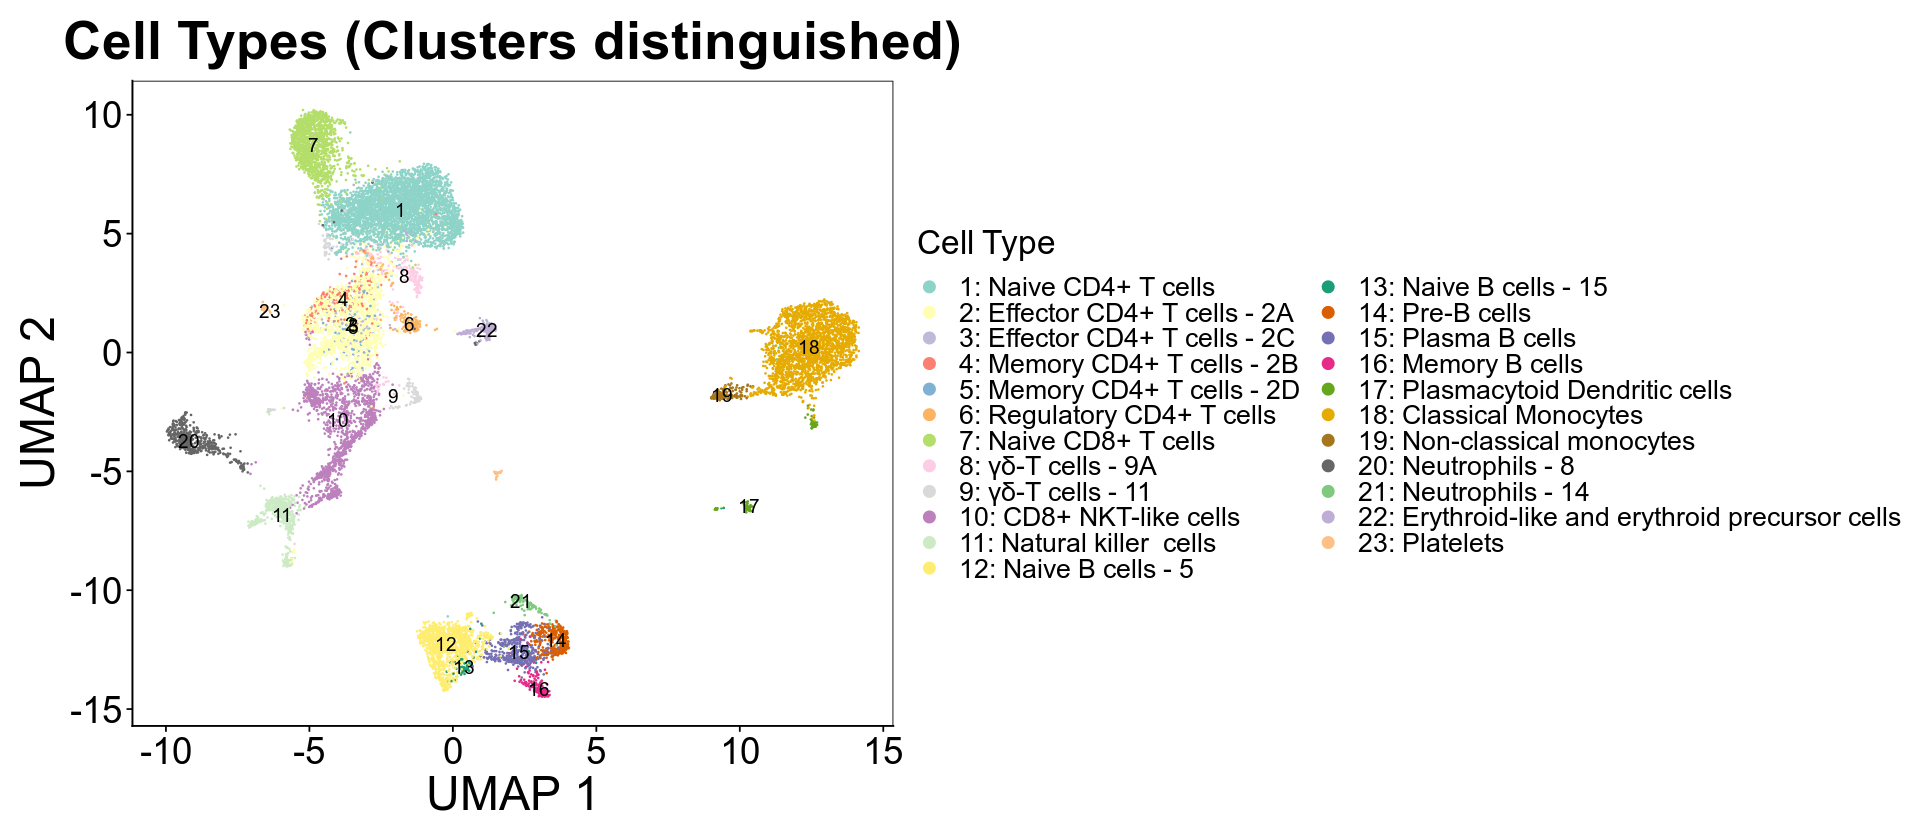

In [627]:
h_ = 7
w_ = 16
options(repr.plot.height=h_, repr.plot.width=w_)

colors = c(brewer.pal(n=12, "Set3"),
           brewer.pal(n=8, "Dark2"), 
           brewer.pal(n=3, "Accent"))
theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=28), legend.text=element_text(size=16), 
         legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
             axis.text.y = element_text(size = 22)) 

g4<-DimPlot(pbmc.integrated, reduction = 'umap',  
            group.by = 'Cell.Type.forUMAP', label = T)+
    xlab('UMAP 1')+ylab('UMAP 2')+
    scale_color_manual(values = colors, labels = legend.labels) + labs(color='Cell Type')+theme+
    ggtitle('Cell Types (Clusters distinguished)')
g4

A few notes:

- It looks like for every cell type that mapped to multiple clusters except neutrophils & gamma-delta Ts, we can disregard that they mapped to different clusters, since these clusters are near each other in UMAP space. Also, we won't focus on neutrophils, we probably don't need to distinguish this in the main. 
- Patient specific clusters 8, 10, & 14:
    - Neutrophils
        - Clusters 8 and 14 are the neutrophils. Cluster 14 was somewhat high in MT % so that's probably why the cluster separately. 
        - Cluster 8/neutrophils in general lyse easily and are difficult to sequence. We may/may not keep them for downstream analyses & visualizations. To disregard, in methods we can justify by talking about how they lyse easily so anything labeled as neutrophil was ignored bc we didn't use neutrophil specific protocols (this would eliminate these patient-specific populations). 
        - If we do disregard, this can effect the compositional analysis (but not the DE). 
    -Cluster 10: Erythroid precursos (remnants of original analysis patient-specific cluster 5)
- gamma-delta T-cells clusters 9A & 11:
    - Cluster 9 was originally labelled gamma-delta, but seemed mixed from markers. Clearly separated into Tregs (9B) & gamma delta.
    - Cluster 11 was also originally labelled gamma-delta, and this seemed consistent. 
    - Why are they separate? We suspect they are in different activation states (more naive-like vs effector-like). 
    - What to do with them? We will keep them grouped in the more granular label of gamma-delta, despite them separating in the UMAP into distinct clusters.  
    
Regardless, since the main populations of interest (NK, T cells) all group together (bullet point 1), DE analyses won't be effected by this.  

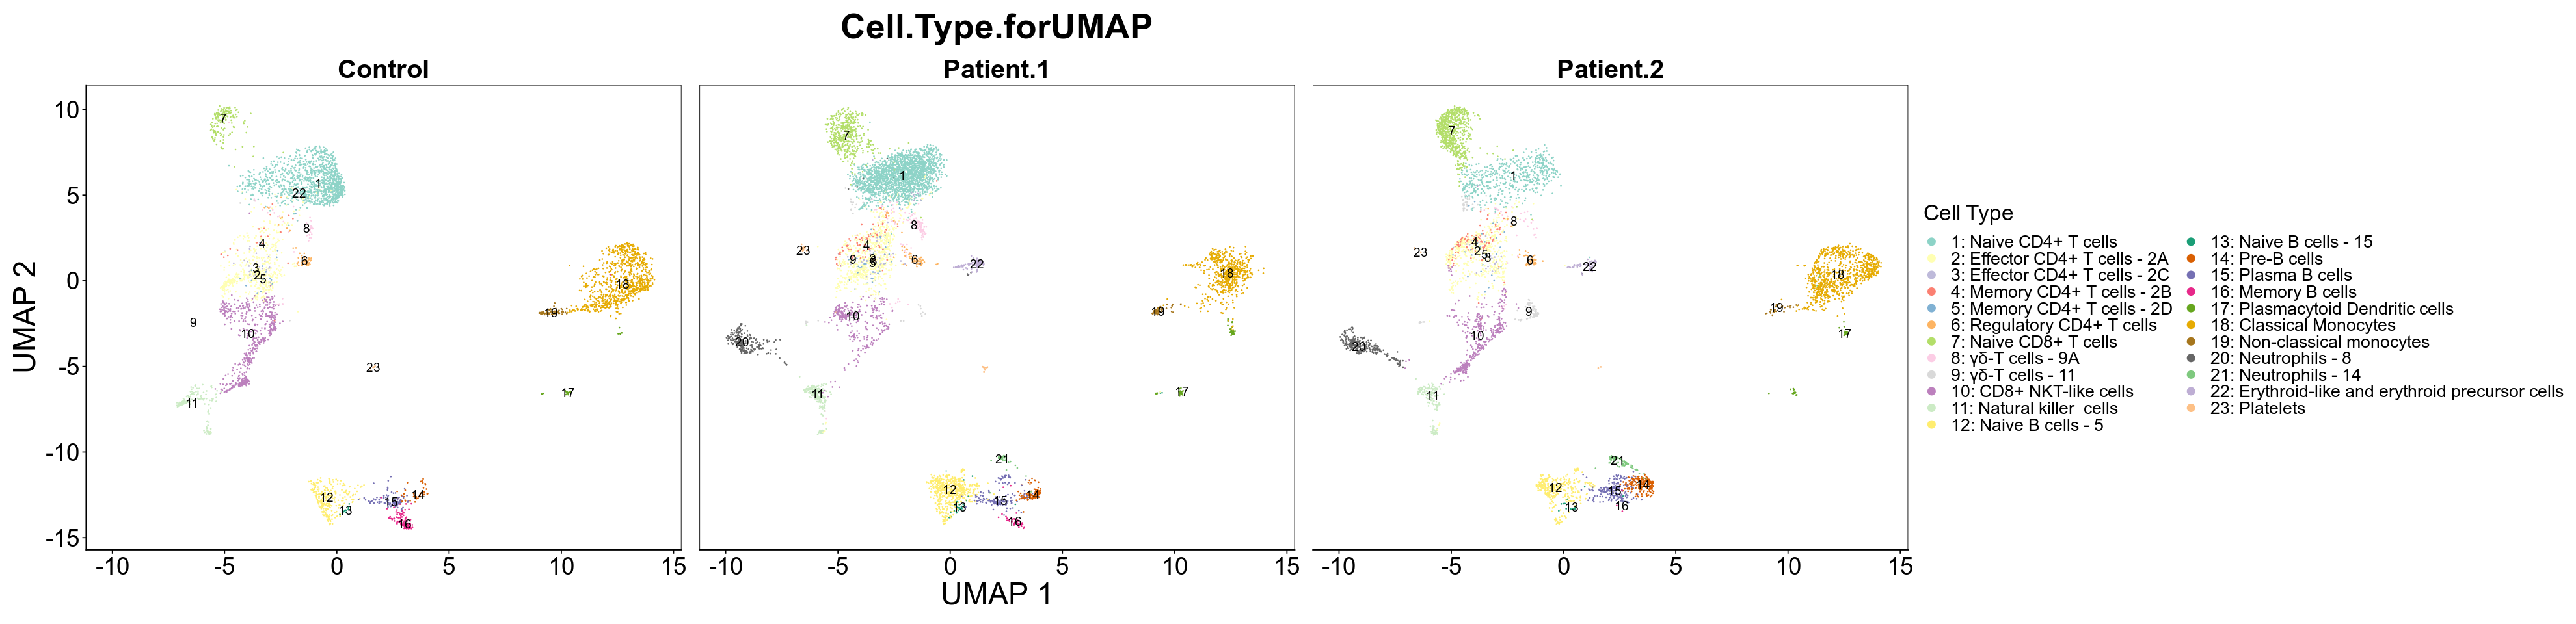

In [625]:
h_ = 8
w_ = 33
options(repr.plot.height=h_, repr.plot.width=w_)

colors = c(brewer.pal(n=12, "Set3"),
           brewer.pal(n=8, "Dark2"), 
           brewer.pal(n=3, "Accent"))
theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=28), legend.text=element_text(size=16), 
         legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
             axis.text.y = element_text(size = 22)) 

g4<-DimPlot(pbmc.integrated, reduction = 'umap',  
            group.by = 'Cell.Type.forUMAP', split.by = 'orig.ident', label = T)+
    xlab('UMAP 1')+ylab('UMAP 2')+
    scale_color_manual(values = colors, labels = legend.labels) + labs(color='Cell Type')+theme
g4

In [629]:
table(md$Cell.Type.uniquecluster)


                          Naive CD4+ T cells 
                                        3765 
                  Effector CD4+ T cells - 2A 
                                        1723 
                  Effector CD4+ T cells - 2C 
                                          86 
                    Memory CD4+ T cells - 2B 
                                         195 
                    Memory CD4+ T cells - 2D 
                                          78 
                     Regulatory CD4+ T cells 
                                         180 
                          Naive CD8+ T cells 
                                        1328 
                             γδ-T cells - 9A 
                                         205 
                             γδ-T cells - 11 
                                         163 
                         CD8+ NKT-like cells 
                                        1276 
                       Natural killer  cells 
                                 

In [630]:
100*table(md$Cell.Type.uniquecluster)/sum(table(md$Cell.Type.uniquecluster))


                          Naive CD4+ T cells 
                                  24.7925721 
                  Effector CD4+ T cells - 2A 
                                  11.3459766 
                  Effector CD4+ T cells - 2C 
                                   0.5663111 
                    Memory CD4+ T cells - 2B 
                                   1.2840774 
                    Memory CD4+ T cells - 2D 
                                   0.5136310 
                     Regulatory CD4+ T cells 
                                   1.1853023 
                          Naive CD8+ T cells 
                                   8.7448966 
                             γδ-T cells - 9A 
                                   1.3499276 
                             γδ-T cells - 11 
                                   1.0733570 
                         CD8+ NKT-like cells 
                                   8.4024760 
                       Natural killer  cells 
                                 

In [635]:
sort(table(md$Cell.Type)[table(md$Cell.Type) < 350])


                                   Platelets 
                                          49 
                Plasmacytoid Dendritic cells 
                                         143 
                     Non-classical monocytes 
                                         157 
                              Memory B cells 
                                         168 
                     Regulatory CD4+ T cells 
                                         180 
Erythroid-like and erythroid precursor cells 
                                         181 
                         Memory CD4+ T cells 
                                         273 
                                 Pre-B cells 
                                         341 

### Final UMAP

In [7]:
pbmc.integrated<-readRDS(paste0(data_path, 'processed/pbmc_integrated.RDS'))

In [23]:
co<-c('Naive CD4+ T cells', 'Effector CD4+ T cells', 'Memory CD4+ T cells', 'Regulatory CD4+ T cells', 
       'Naive CD8+ T cells', 'γδ-T cells', 'CD8+ NKT-like cells', 'Natural killer  cells', 
       'Naive B cells', 'Pre-B cells', 'Plasma B cells', 'Memory B cells',
 'Plasmacytoid Dendritic cells', 'Classical Monocytes', 'Non-classical monocytes', 'Neutrophils',
  'Erythroid-like and erythroid precursor cells', 'Platelets'
 )

umap_labs<-1:length(co)
names(umap_labs)<-co

md[['Cell.Type.UMAP']]<-factor(x = unname(umap_labs[md$Cell.Type]), 
                               levels = unname(umap_labs))

pbmc.integrated@meta.data<-md

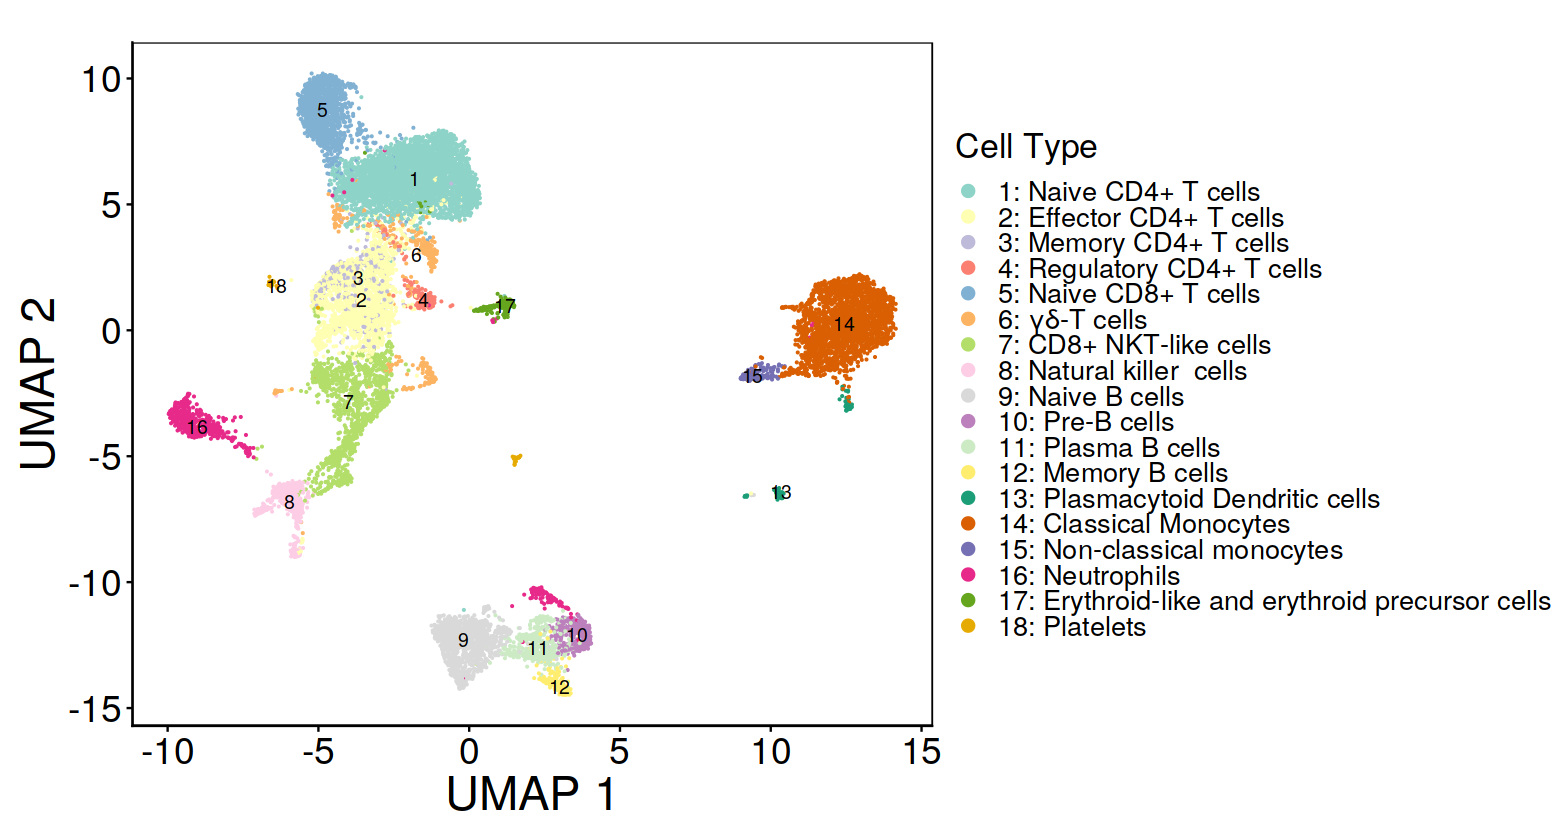

In [31]:
h_ = 7
w_ = 13
options(repr.plot.height=h_, repr.plot.width=w_)

colors = c(brewer.pal(n=12, "Set3"),
           brewer.pal(n=8, "Dark2"), 
           brewer.pal(n=3, "Accent"))
theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=28), legend.text=element_text(size=16), 
         legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
             axis.text.y = element_text(size = 22)) 

g6<-DimPlot(pbmc.integrated, reduction = 'umap',  
            group.by = 'Cell.Type.UMAP', label = T)+
    xlab('UMAP 1')+ylab('UMAP 2')+
    scale_color_manual(values = colors, 
                       labels = paste0(unname(umap_labs), ': ', names(umap_labs))) + 
    labs(color='Cell Type')+theme + ggtitle(element_blank())
suppressWarnings({
    for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                         'UMAP_all_final', ext), g6, 
                                                 height = h_, width = w_)}
})


g6



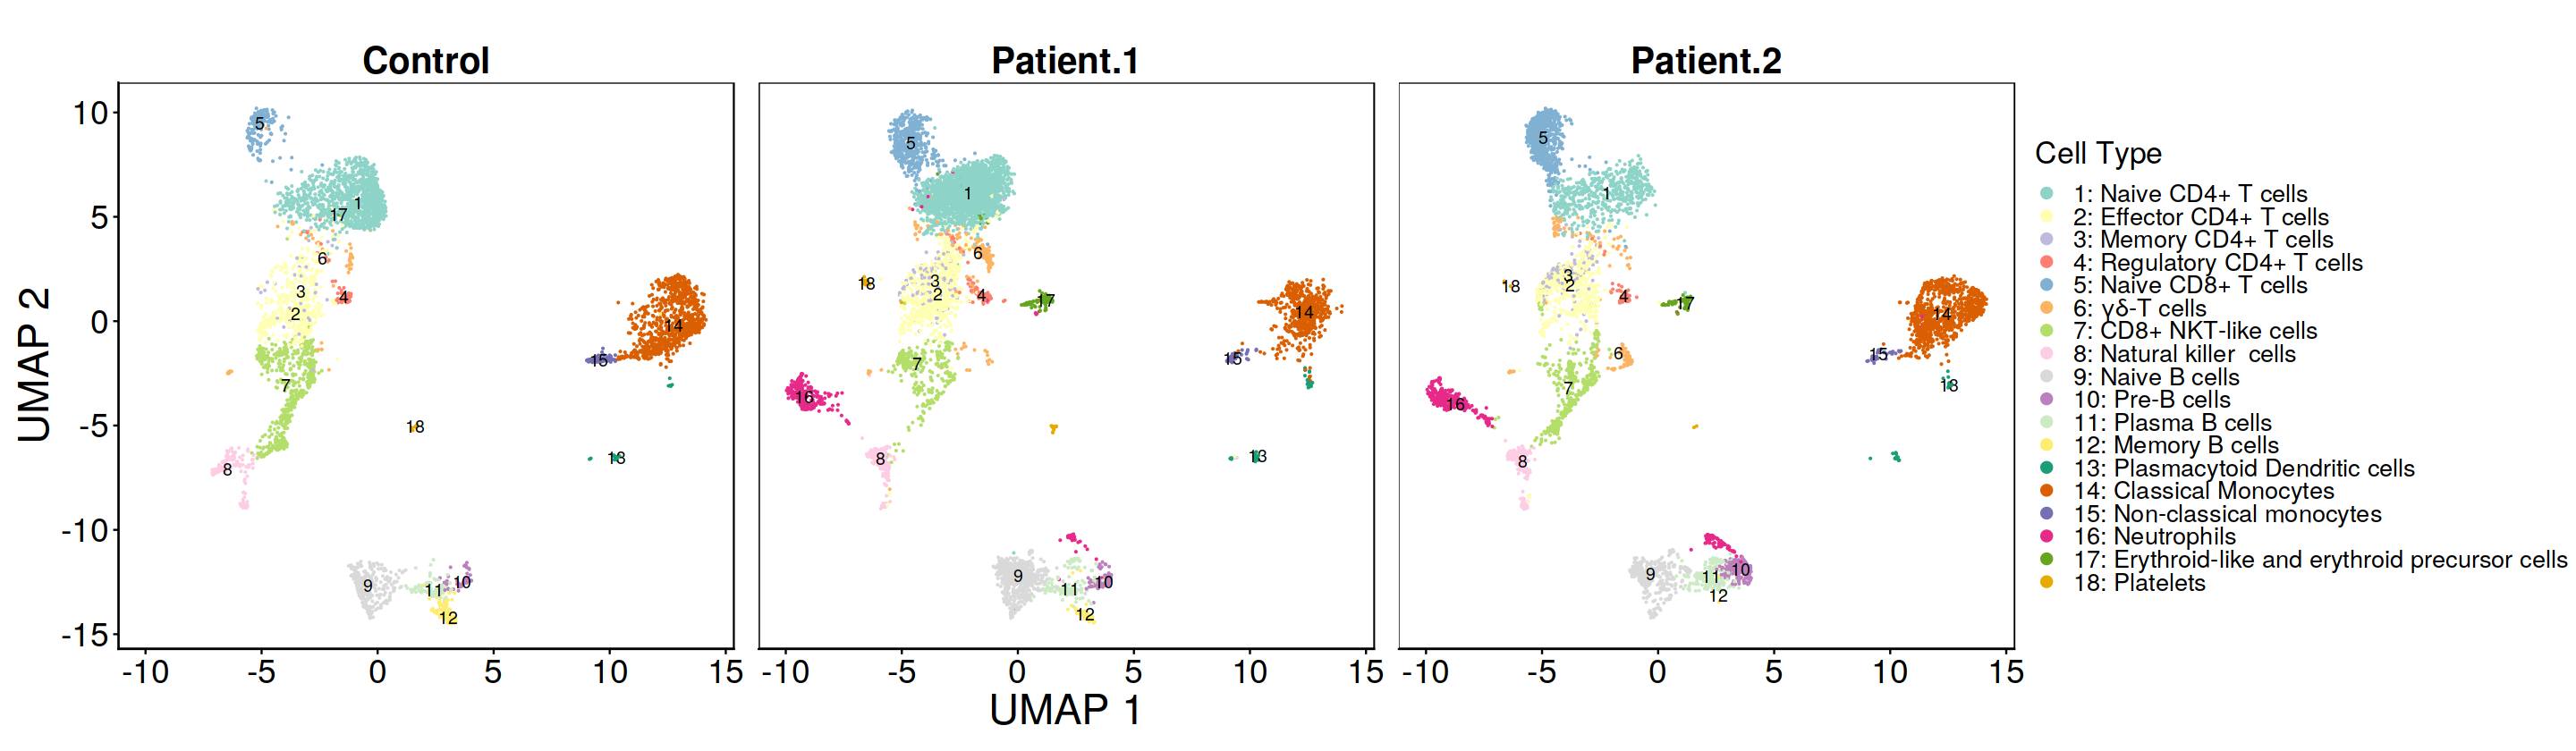

In [33]:
h_ = 7
w_ = 24
options(repr.plot.height=h_, repr.plot.width=w_)

colors = c(brewer.pal(n=12, "Set3"),
           brewer.pal(n=8, "Dark2"), 
           brewer.pal(n=3, "Accent"))
theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=28), legend.text=element_text(size=16), 
         legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
             axis.text.y = element_text(size = 22)) 

g7<-DimPlot(pbmc.integrated, reduction = 'umap',  
            group.by = 'Cell.Type.UMAP', split.by = 'orig.ident', label = T)+
    xlab('UMAP 1')+ylab('UMAP 2')+
    scale_color_manual(values = colors, 
                       labels = paste0(unname(umap_labs), ': ', names(umap_labs))) + 
    labs(color='Cell Type')+theme + ggtitle(element_blank())

suppressWarnings({
    for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                         'UMAP_samples_final', ext), g7, 
                                                 height = h_, width = w_)}
})


g7